In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rxr
import xarray as xr
import seaborn as sns
from matplotlib.patches import Rectangle


### Defining paths 

In [2]:
# defining paths
path_to_npys_data = os.path.join("..", "data", "npys_data")

path_to_geo_data = os.path.join("..", "data", "geo_data")

pathTarget = os.path.join(path_to_npys_data, "target_croplands.npy")

pathPrediction = os.path.join("..", "results", "2040_2050", "lstm_ssp245_average_prob.npy")

path_to_figs = os.path.join("..", "results", "prob_subs")


### Loading required datasets

In [3]:
# Loading GFSAD cropmask and use it as initial probability distribution. Class 4 denotes Nans in the dataset.

with open(pathTarget, 'rb') as f:
    init_data = pickle.load(f)
    tgt = init_data["Target"]
    # Set classes 4,5 to 0
    tgt[np.isnan(tgt)] = 6
    tgt = tgt.astype(np.int16)
    tgt = np.where(tgt == 5, 0, tgt)
    tgt = np.where(tgt == 4, 0, tgt)
    tgt = np.where(tgt == 6, 4, tgt)
    uniques = np.unique(tgt)
    n_values = len(uniques)
    tgt_ohe = np.eye(n_values)[tgt]
    init_data = tgt_ohe


In [4]:
# Load prediction and filters

# Predicted probabilites by LSTM model for 2050 year 
with open(pathPrediction, 'rb') as f:
    predicted_prob = pickle.load(f)

# Tif file where 0s represent water area (no cropland is possible)
filter_water = rxr.open_rasterio(
    os.path.join(path_to_geo_data, "filter_water.tif")
).squeeze()

# Tif file where 0s represent area with slope > 5 degrees (no cropland is possible)
filter_slope = rxr.open_rasterio(
    os.path.join(path_to_geo_data, "filter_slope.tif")
).squeeze()


### Plot probabilities difference with initial cropmask for prediction

class diff 0


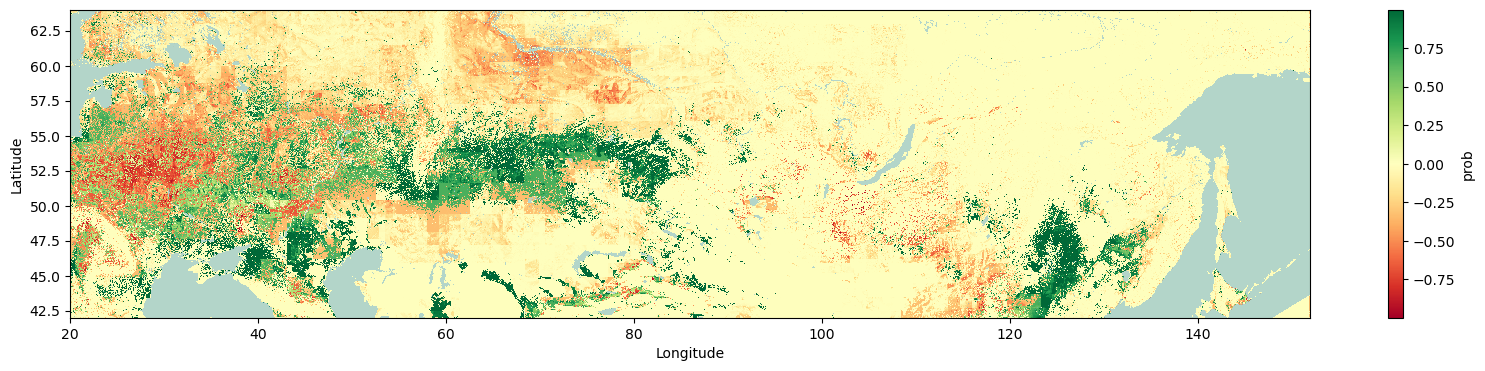

class diff 1


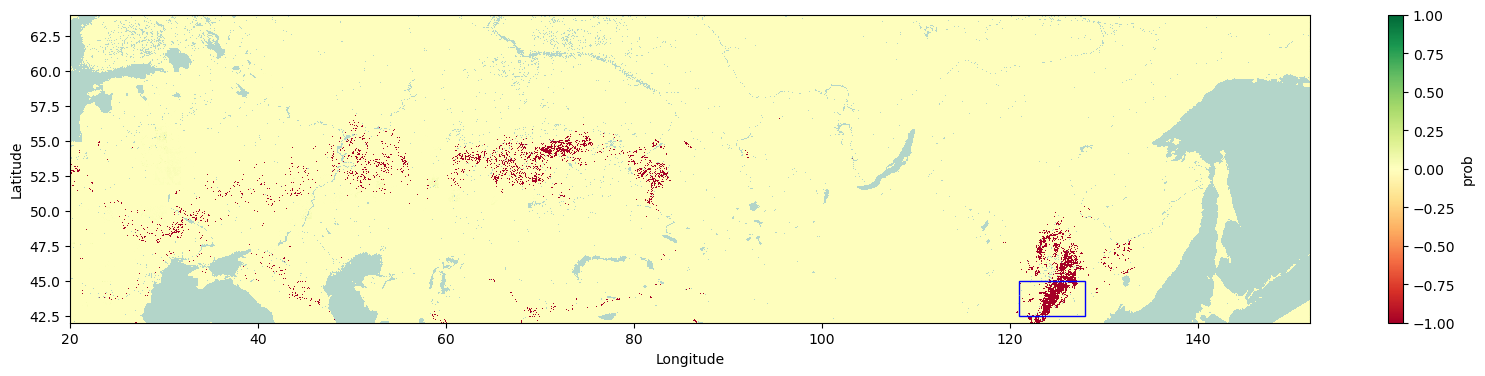

class diff 2


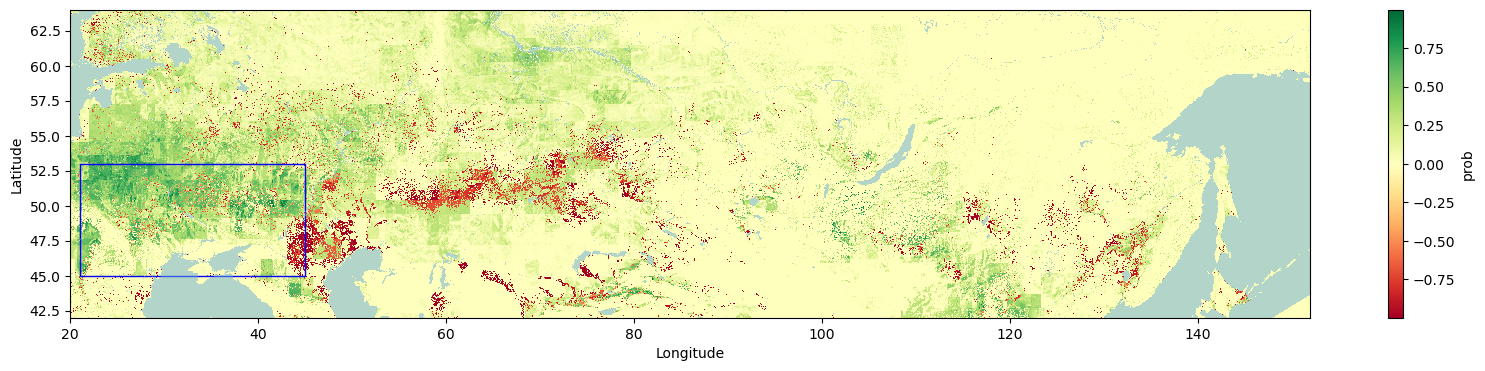

class diff 3


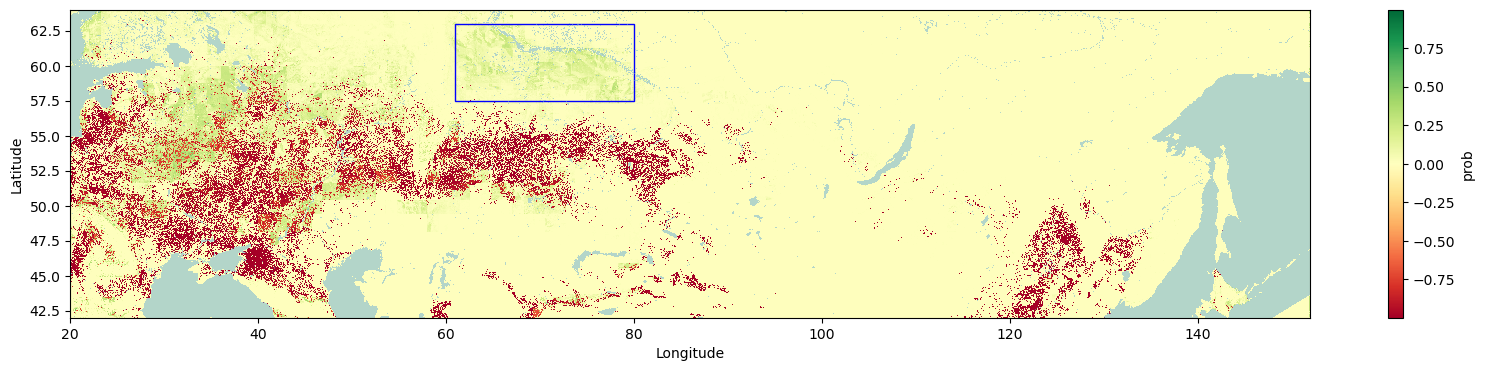

In [5]:
# Define dimensions for xr.DataArray based on Filter file:
y, x = filter_slope.indexes.values()
lot = y.shape[0]

# Plot heatmap for each class:
for j in range(4):
    predicted_prob_filtered = [
        z * h for z, h in zip(predicted_prob[:, j].reshape(lot, -1), filter_water.values)
    ]
    init_data_filtered = [
        z * h for z, h in zip(init_data[:, j].reshape(lot, -1), filter_water.values)
    ]
    predicted_prob_filtered = [z * h for z, h in zip(predicted_prob_filtered, filter_slope.values)]
    init_data_filtered = [z * h for z, h in zip(init_data_filtered, filter_slope.values)]

    diff_probability = np.subtract(predicted_prob_filtered, init_data_filtered)
    diff_probability = diff_probability.reshape(-1)
    
    # Add rectangles
    rectangles = [(45, 121, 42.5, 128),   # [ul_corner_y, ul_corner_x, lr_corner_y, lr_corner_x]
                (53, 21, 45, 45),
                (63, 61, 57.5, 80)]
    
    filter_water_ = filter_water.where(filter_water == 0)
    diff_probability = xr.DataArray(
        diff_probability.reshape(lot, -1), dims=["y", "x"], coords=dict(y=y, x=x)
    )
    diff_probability.name = 'prob'

    # Plotting
    fig, gax = plt.subplots(figsize=(20, 4))
    
    # Plot rectangle
    if j != 0:
        ul_corner_y, ul_corner_x, lr_corner_y, lr_corner_x = rectangles[j-1]
        width = lr_corner_x - ul_corner_x
        height = lr_corner_y - ul_corner_y
        rect = Rectangle((ul_corner_x, ul_corner_y), width, height, linewidth=1, edgecolor='b', facecolor='none')
        gax.add_patch(rect)
        
    # Plot heatmap    
    filter_water_.plot(ax=gax, cmap='Blues', add_colorbar=False, alpha=0.5)
    diff_probability.plot.imshow(ax=gax, cmap='RdYlGn')
    plt.savefig(os.path.join(path_to_figs, 'lstm_ssp245_average_class_diff_' + str(j) + '.png'))
    print('class diff ' + str(j))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
    plt.close(fig)
